# Prediction model 

This jupyter notebook walks through what we have done for the prediction model

## Import packages

In [83]:
import numpy as np
import pandas as pd

## Data propressing

Data proprecessing includes:

- Flip favourable and unfavourable
- Filter all closed cases
- Drop unuseful columns
- Transform data type (to save memory)
- Clean claims (convert to numeric and then categorical)
- Dummify variables to make sure models can use

In [30]:
data  = pd.read_pickle('allYear.pkl')

no_effect = ['Favorable','Partially Favorable','Dismissed','Remanded','Removal to MAC/DAB','No Disposition','Escalated','Exp Acc to Judicial Review','Invalid Request']
    
data['Disposition'] = data['Disposition'].apply(lambda x : 0 if x in no_effect else 1)

data = data[data['Appeal Status'] == 'Closed']

data = data.drop(labels = ['FY','ALJ Number','Recd Date','Request Type','OTR','Hearing Completed Date','Hearing Format',
                           'Procedure Description','Decision Letter Mailed Date',
                          'Hearing Type','Appeal Status'], axis = 1)

data['Disposition']=data.Disposition.astype('int8')
data['Claims']=data.Claims.apply(lambda x:str(x).replace(",","")).astype("int16")

catClaims, bins = pd.cut(data.Claims,8,labels=["level"+str(i) for i in range(8)],retbins=True)

data['Claims'] = catClaims
del catClaims

data['Claims'] = data['Claims'].astype(str)
data.dtypes

Claims             object
Appeal Category    object
Medicare Part      object
Requestor Type     object
State              object
PSC/ZPIC           object
RAC                object
Disposition          int8
Procedure Code     object
dtype: object

In [31]:
data = pd.get_dummies(data,drop_first= True)

In [32]:
data.shape

(722046, 7428)

In [33]:
X=data.drop('Disposition',axis=1)
y = data['Disposition']
del data

In [34]:
y.value_counts()

0    537421
1    184625
Name: Disposition, dtype: int64

In [35]:
y.mean()

0.25569700545394614

In [36]:
X.shape

(722046, 7427)

In [84]:
X_new.head()

,Requestor Type_Provider,Requestor Type_State Medicaid Agency,State_NY,State_CA,Appeal Category_Home Health/Hospice,Medicare Part_Part B,State_FL,Appeal Category_Acute Hospital,State_MA,Medicare Part_Part C,...,Procedure Code_77051,Procedure Code_73510,Procedure Code_86703,Procedure Code_L5590,Procedure Code_E0600,Procedure Code_J2060,Procedure Code_J1441,Procedure Code_C1760,Procedure Code_1CGK3,Procedure Code_44120
1812,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1817,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1822,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1824,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1827,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_jobs=-1,n_estimators=10)
model.fit(X, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
feature_imp = pd.DataFrame(list(zip(X.columns, model.feature_importances_)), columns = ['feature','importance']).sort_values(by = 'importance', ascending = False)

print(feature_imp)

                                    feature  importance
58                  Requestor Type_Provider    0.024767
59     Requestor Type_State Medicaid Agency    0.023445
96                                 State_NY    0.019583
63                                 State_CA    0.018179
14      Appeal Category_Home Health/Hospice    0.013949
41                     Medicare Part_Part B    0.013049
68                                 State_FL    0.012621
6            Appeal Category_Acute Hospital    0.012564
80                                 State_MA    0.012544
43                     Medicare Part_Part C    0.011697
50               Requestor Type_Beneficiary    0.011692
5652                   Procedure Code_G0154    0.009909
115                            PSC/ZPIC_Yes    0.009827
40                     Medicare Part_Part A    0.009298
30    Appeal Category_Practitioner Services    0.009009
48             Requestor Type_Appointed Rep    0.008946
10                      Appeal Category_DME    0

In [9]:
feature_imp = pd.read_pickle('featureimportance.pkl')

In [37]:
feature_selected = list(feature_imp[feature_imp['importance']>0.0001].feature.values)
len(feature_selected)

1210

Text(0.5,1,'Top 5 importantant features')

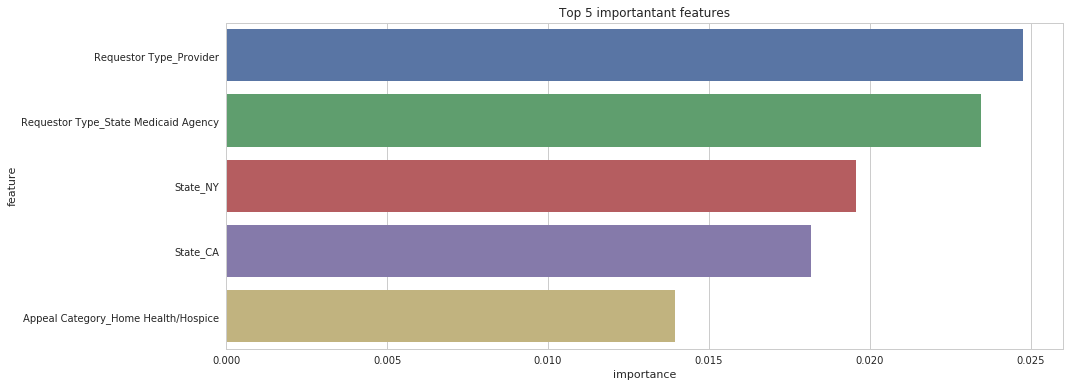

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use("dark_background")
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.barplot(y="feature", x="importance", data=feature_imp.head(5))
plt.title("Top 5 importantant features")

In [29]:
feature_imp.to_pickle("featureimportance.pkl")

In [39]:
X_new = X[feature_selected]
X_new.head()
del X

In [88]:
X_new.head(1).to_csv("features.csv",index=False)

## Modeling

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,precision_recall_curve

X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=42,stratify = y)

In [41]:
def compute_prt(y_pred, y_test):
    result = []
    for i in range(1,1000,1):
        threshold = i/1000
        y_pred_int  = (y_pred[:,1]  >= threshold).astype('int')
        
        #vector = compute_net_profit(y_pred_int,y_test,profits_Xtest)
        
        #TP_Net = vector[0]
        #FP_Net = vector[1]
        #FN_Net = vector[2]
        #TN_Net = vector[3]    

        a = confusion_matrix(y_test,y_pred_int)
#        loss = log_loss(y_test,y_pred_int)
        tp = a[0,0]
        fp = a[0,1]
        fn = a[1,0]
        tn = a[1,1]
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
       
        result.append((threshold, precision, recall,accuracy))
        result_df = pd.DataFrame(result, 
                                 columns = ['Threshold','Precision','Recall','Accuracy']).sort_values(by = 'Precision',
                                                                                                ascending = False)

    return result_df

## XGBoost

In [15]:
#!conda install -y -c conda-forge xgboost

In [42]:
import xgboost as xgb
import sklearn as sk 

bt = xgb.XGBClassifier(n_jobs=-1,n_estimators=30,max_depth=10,scale_pos_weight = 2)

In [43]:
bt.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
       seed=None, silent=True, subsample=1)

In [44]:
y_pred_bt =  bt.predict_proba(X_test)
#bt_Result = compute_prt(y_pred_bt, y_test )

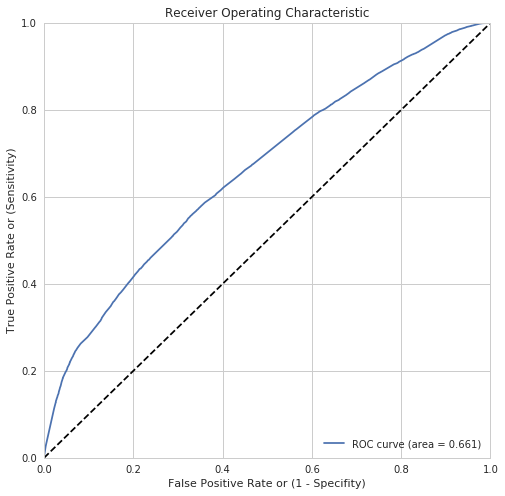

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bt[:,1])
roc_auc = auc(fpr, tpr)
#roc_auc=1
# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [46]:
del fpr,tpr,thresholds,roc_auc,y_pred_bt,bt

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,n_jobs=-1)
clf.fit(X_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
y_pred_cl = clf.predict_proba(X_test)

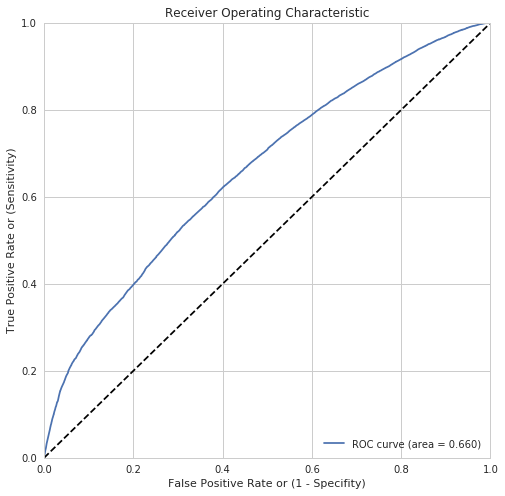

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_cl[:,1])
roc_auc = auc(fpr, tpr)
#roc_auc=1
# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Random forest

In [50]:
rf = RandomForestClassifier(n_estimators= 70, n_jobs= -1,class_weight={0:1,1:2})
rf.fit(X_train,y_train)
y_pred_rf1 =  rf.predict_proba(X_test)
#RF_Result = compute_prt(y_pred_rf1, y_test )

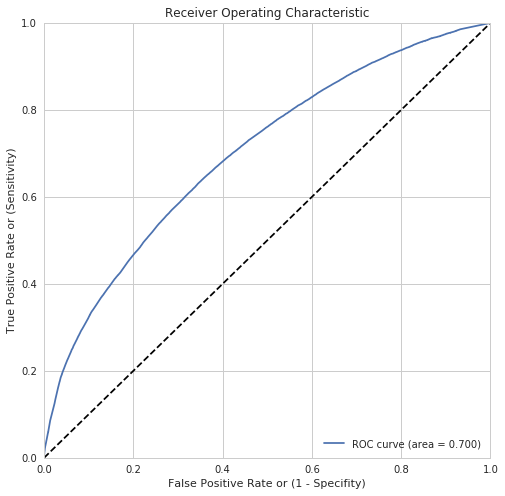

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf1[:,1])
roc_auc = auc(fpr, tpr)
#roc_auc=1
# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [52]:
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.81      0.84      0.82    107485
          1       0.47      0.41      0.44     36925

avg / total       0.72      0.73      0.73    144410



In [93]:
y_test.sort_index()

0         0
0         0
1         0
4         0
4         1
4         1
5         1
7         0
9         0
14        0
15        0
16        0
16        1
17        0
17        0
24        1
25        1
25        0
26        0
28        0
28        0
29        0
30        0
32        0
32        1
33        0
34        0
35        0
36        0
43        0
         ..
389922    0
389983    0
389992    0
389994    0
390014    1
390022    0
390025    0
390048    0
390062    0
390090    0
390106    0
390194    0
390197    0
390198    0
390206    0
390226    0
390228    0
390250    1
390296    0
390311    1
390357    0
390358    0
390360    1
390365    0
390366    0
390397    1
390445    0
390446    0
390474    0
390477    0
Name: Disposition, Length: 144410, dtype: int8

In [53]:
cm= confusion_matrix(y_test,y_pred)

Text(0.5,1,'confusion_matrix')

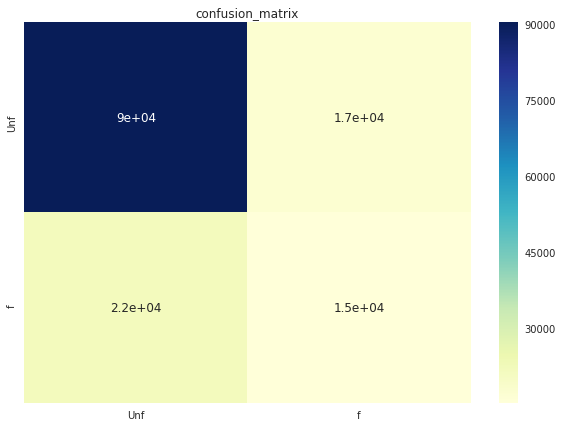

In [54]:
df_cm = pd.DataFrame(cm, index = [i for i in ["Unf","f"]],
                  columns = [i for i in ["Unf","f"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="YlGnBu")
plt.title("confusion_matrix")

In [55]:
y.mean()

0.25569700545394614

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7314590402326708

In [57]:
rf_Result = compute_prt(y_pred_rf1, y_test )

In [80]:
rf_Result.to_csv("rfresult.csv")

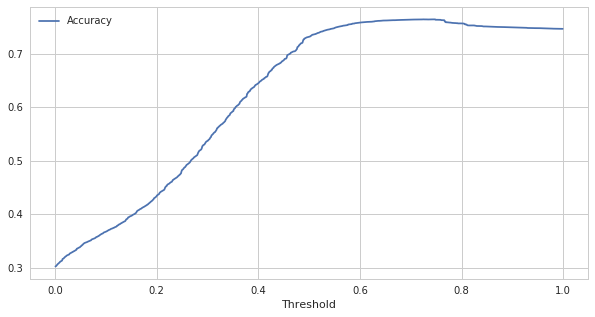

In [69]:
rf_Result.plot(x='Threshold',y='Accuracy',figsize=(10,5))

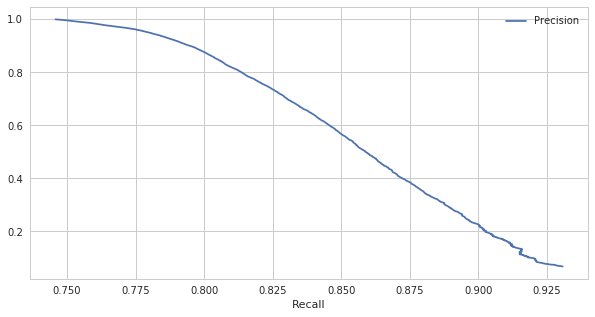

In [70]:
rf_Result.plot(y='Precision',x='Recall',figsize=(10,5))

In [79]:
rf_Result[rf_Result['Threshold']>0.5].sort_values("Accuracy",ascending=False)

,Threshold,Precision,Recall,Accuracy
725,0.726,0.958273,0.776690,0.763874
739,0.740,0.961650,0.775184,0.763874
741,0.742,0.961883,0.775081,0.763874
740,0.741,0.961734,0.775135,0.763860
727,0.728,0.958841,0.776418,0.763853
738,0.739,0.961576,0.775199,0.763853
743,0.744,0.962320,0.774858,0.763839
747,0.748,0.963316,0.774418,0.763839
729,0.730,0.959194,0.776237,0.763825
736,0.737,0.961390,0.775253,0.763818


In [81]:
import pickle
# now you can save it to a file
with open('finalmodel.pkl', 'wb') as f:
    pickle.dump(rf, f)

---------------------------- end ----------------------------------

## MLP

In [ ]:
#rf = DecisionTreeClassifier(max_features=200)
#rf = RandomForestClassifier(n_estimators= 100,max_features=400, n_jobs= -1)
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(512, 256,128), random_state=1)

clf.fit(X_train,y_train)                         
#rf.fit(X_train,y_train,y_train+8)


# #### Log Loss Random Forest1

y_pred_rf1 =  clf.predict_proba(X_test)

RF_Result = compute_prt(y_pred_rf1, y_test )

In [ ]:
y_pred_rf1 =  clf.predict_proba(X_test)


In [ ]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

In [ ]:


# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf1[:,1])
roc_auc = auc(fpr, tpr)
#roc_auc=1
# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Adaboost

In [22]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()

clf.fit(X_train, y_train)                         
#rf.fit(X_train,y_train,y_train+8)


# #### Log Loss Random Forest1

y_pred_rf1 =  clf.predict_proba(X_test)

RF_Result = compute_prt(y_pred_rf1, y_test )

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [23]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.27      0.03      0.05      3722
          1       0.97      1.00      0.99    140688

avg / total       0.96      0.97      0.96    144410



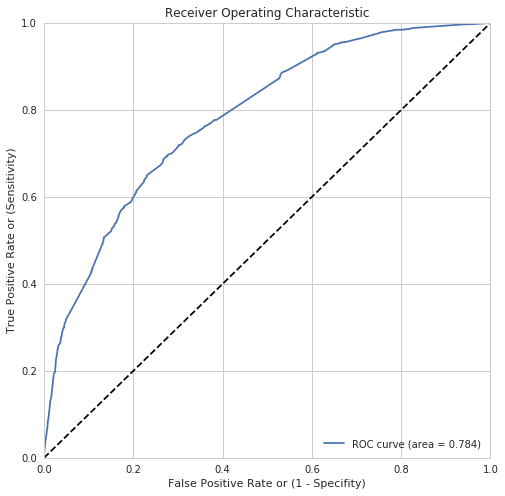

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf1[:,1])
roc_auc = auc(fpr, tpr)
#roc_auc=1
# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")